# Personality type prediction
The Myers Briggs Type Indicator (or MBTI for short) is a personality type system that divides everyone into 16 distinct personality types across 4 axis:

1) Introversion (I) – Extroversion (E) : a measure of how much an individual prefers their outer or inner world.

2) Intuition (N) – Sensing (S) : a measure of how much an individual processes information through the five senses versus impressions through patterns

3) Thinking (T) – Feeling (F) : a measure of preference for objective principles and facts versus weighing the emotional perspectives of others.

4) Judging (J) – Perceiving (P) : a measure of how much an individual prefers a planned and ordered life versus a flexible and spontaneous life.


Data prep and cleaning

In [28]:
import opendatasets as od

od.download('https://www.kaggle.com/kaggle/meta-kaggle')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle Key:Downloading meta-kaggle.zip to .\meta-kaggle


100%|██████████| 6.09G/6.09G [04:59<00:00, 21.9MB/s]


In [29]:
import re
from time import time
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from nltk.stem.snowball import SnowballStemmer

In [30]:
train_data = pd.read_csv('./mbti_1.csv')
forum_data = pd.read_csv('meta-kaggle/ForumMessages.csv')
mbti = {'I':'Introversion', 'E':'Extroversion', 'N':'Intuition', 
        'S':'Sensing', 'T':'Thinking', 'F': 'Feeling', 
        'J':'Judging', 'P': 'Perceiving'}

In [31]:
train_data.shape

(8675, 2)

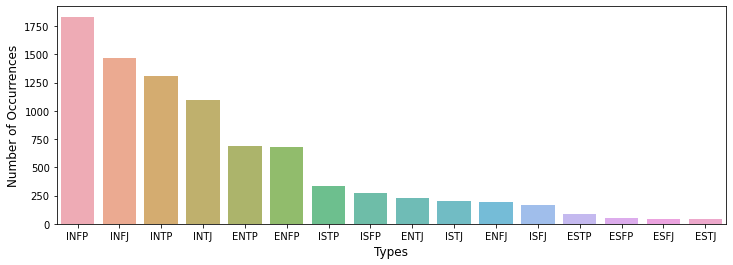

In [32]:
type_count = train_data['type'].value_counts()

plt.figure(figsize=(12,4))
sns.barplot(x=type_count.index, y=type_count.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Types', fontsize=12)
plt.show()

In [33]:
print('Forum Missing Values:')
print(forum_data.isnull().sum())

Forum Missing Values:
Id                             0
ForumTopicId                   0
PostUserId                     0
PostDate                       0
ReplyToForumMessageId     991908
Message                     7169
Medal                    1069997
MedalAwardDate           1061138
dtype: int64


In [34]:
print('Training Missing Values:')
print(train_data.isnull().sum())

Training Missing Values:
type     0
posts    0
dtype: int64


In [35]:
forum_data['Message'] = forum_data['Message'].fillna('')

print('Forum Missing Values:')
print(forum_data.isnull().sum())

Forum Missing Values:
Id                             0
ForumTopicId                   0
PostUserId                     0
PostDate                       0
ReplyToForumMessageId     991908
Message                        0
Medal                    1069997
MedalAwardDate           1061138
dtype: int64


In [36]:
print(forum_data['PostUserId'].value_counts())

3012786     19818
75976        9794
1723677      8404
10654180     7175
113660       6176
            ...  
5417935         1
3267530         1
5367543         1
2110846         1
8597061         1
Name: PostUserId, Length: 307789, dtype: int64


In [37]:
forum_data_agg = forum_data.groupby('PostUserId')['Message'].agg(lambda col: ' '.join(col)).reset_index()

In [38]:
print(forum_data_agg['PostUserId'].value_counts())

62          1
5895914     1
5895889     1
5895886     1
5895832     1
           ..
2215049     1
2215034     1
2214981     1
2214962     1
14369380    1
Name: PostUserId, Length: 307789, dtype: int64


In [39]:
#function to clean data
def clean_text(text):
    #get rid of html and seperators
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r'  ', text) 
    text = re.sub(r'http\S+', r'  ', text)
    #get rid of punctuation
    text = text.replace('.', '  ')
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    #get rid of numbers
    text = ''.join(i for i in text if not i.isdigit())
    return text

In [40]:
train_data['clean_posts'] = train_data['posts'].apply(clean_text)

C:\Users\eleed\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [41]:
train_data['clean_posts'][1]

'Im finding the lack of me in these posts very alarming    Sex can be boring if its in the same position often   For example me and my girlfriend are currently in an environment where we have to creatively use cowgirl and missionary   There isnt enough        Giving new meaning to Game theory    Hello ENTP Grin  Thats all it takes   Than we converse and they do most of the flirting while I acknowledge their presence and return their words with smooth wordplay and more cheeky grins    This  Lack of Balance and Hand Eye Coordination    Real IQ test I score    Internet IQ tests are funny   I score s or higher    Now like the former responses of this thread I will mention that I dont believe in the IQ test   Before you banish        You know youre an ENTP when you vanish from a site for a year and a half return and find people are still commenting on your posts and liking your ideasthoughts   You know youre an ENTP when you                I over think things sometimes   I go by the old She

In [42]:
forum_data_agg['clean_messages'] = forum_data_agg['Message'].apply(clean_text)

In [43]:
forum_data_agg['clean_messages'][1]

'Hi Tanya Kaggle will maintain a rating system   If you win but youre ineligible for prize money you will still get a strong rating  Anthony Here are some papers that analyze Eurovision voting patterns   You might find some of them helpful   Gatherer Comparison of Eurovision Song Contest Simulation with Actual Results Reveals Shifting Patterns of Collusive Voting Alliances      Eurovision Song Contest Is Voting Political or Cultural Ginburgh and Noury    Suleman Efstathiou and Johnson    Eurovision Song Contest as a ‘Friendship’ Network\r\nDekker   \n More research       enjoyLove thy Neighbor Love thy Kin Voting Biases in the Eurovision Song Contest   culture and religion Explaining the bias in Eurovision song contest voting   Hybrid System Approach to Determine the Ranking of a Debutant Country in Eurovision   Eurovision   Judgment Versus Public Opinion – Evidence from the Eurovision Song Contest   GiovanniThanks for your feedback   Using the forum to give feedback is a good idea   I

In [44]:
#function to split string by uppercase
def split_uppercase(text):
    text_list = text.split()
    new_list = []
    for i in text_list:
        if i.isupper() == False: #don't split acronyms
            word = re.sub(r'([A-Z])', r' \1', i)
            new_list.append(word)
        else:
            word = i
            new_list.append(word)
    words = ' '.join(new_list)
    return words
            

In [45]:
forum_data_agg['clean_messages'] = forum_data_agg['clean_messages'].apply(split_uppercase)

In [46]:
forum_data_agg['clean_messages'][1]

' Hi  Tanya  Kaggle will maintain a rating system  If you win but youre ineligible for prize money you will still get a strong rating  Anthony  Here are some papers that analyze  Eurovision voting patterns  You might find some of them helpful  Gatherer  Comparison of  Eurovision  Song  Contest  Simulation with  Actual  Results  Reveals  Shifting  Patterns of  Collusive  Voting  Alliances  Eurovision  Song  Contest  Is  Voting  Political or  Cultural  Ginburgh and  Noury  Suleman  Efstathiou and  Johnson  Eurovision  Song  Contest as a ‘ Friendship’  Network  Dekker  More research enjoy Love thy  Neighbor  Love thy  Kin  Voting  Biases in the  Eurovision  Song  Contest culture and religion  Explaining the bias in  Eurovision song contest voting  Hybrid  System  Approach to  Determine the  Ranking of a  Debutant  Country in  Eurovision  Eurovision  Judgment  Versus  Public  Opinion –  Evidence from the  Eurovision  Song  Contest  Giovanni Thanks for your feedback  Using the forum to give

In [47]:
#function to stem words
def stem_text(text):
    stemmer = SnowballStemmer('english')
    words_list = text.split()
    new_list = []
    for i in words_list:
        word = stemmer.stem(i)
        new_list.append(word)
        
    words = new_list
    words = ' '.join(words)
    return words

In [48]:
train_data['clean_posts'] = train_data['clean_posts'].apply(stem_text)

In [49]:
train_data['clean_posts'][1]

'im find the lack of me in these post veri alarm sex can be bore if it in the same posit often for exampl me and my girlfriend are current in an environ where we have to creativ use cowgirl and missionari there isnt enough give new mean to game theori hello entp grin that all it take than we convers and they do most of the flirt while i acknowledg their presenc and return their word with smooth wordplay and more cheeki grin this lack of balanc and hand eye coordin real iq test i score internet iq test are funni i score s or higher now like the former respons of this thread i will mention that i dont believ in the iq test befor you banish you know your an entp when you vanish from a site for a year and a half return and find peopl are still comment on your post and like your ideasthought you know your an entp when you i over think thing sometim i go by the old sherlock holm quot perhap when a man has special knowledg and special power like my own it rather encourag him to seek a complex

In [50]:
forum_data_agg['clean_messages'] = forum_data_agg['clean_messages'].apply(stem_text)

In [51]:
forum_data_agg['clean_messages'][1]

"hi tanya kaggl will maintain a rate system if you win but your inelig for prize money you will still get a strong rate anthoni here are some paper that analyz eurovis vote pattern you might find some of them help gather comparison of eurovis song contest simul with actual result reveal shift pattern of collus vote allianc eurovis song contest is vote polit or cultur ginburgh and nouri suleman efstathiou and johnson eurovis song contest as a ‘ friendship network dekker more research enjoy love thi neighbor love thi kin vote bias in the eurovis song contest cultur and religion explain the bias in eurovis song contest vote hybrid system approach to determin the rank of a debut countri in eurovis eurovis judgment versus public opinion – evid from the eurovis song contest giovanni thank for your feedback use the forum to give feedback is a good idea it allow other to see and comment on suggest we might set up a proper feedback forum but for the moment this topic will have to suffic i also 

In [52]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import TruncatedSVD

kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

scoring = {'acc': 'accuracy',
           'neg_log_loss': 'neg_log_loss',
           'f1_micro': 'f1_micro'}

ExtraTreesClassifier

In [53]:
etc = ExtraTreesClassifier(n_estimators = 20, max_depth=4, n_jobs = -1)
tfidf = TfidfVectorizer(ngram_range=(1, 1), stop_words='english')
tsvd = TruncatedSVD(n_components=10)
model = Pipeline([('tfidf1', tfidf), ('tsvd1', tsvd), ('etc', etc)])

kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

np.random.seed(1)

results = cross_validate(model, train_data['clean_posts'], train_data['type'], cv=kfolds, 
                          scoring=scoring, n_jobs=-1)



In [54]:
print("CV Accuracy: {:0.4f} (+/- {:0.4f})".format(np.mean(results['test_acc']),
                                                  np.std(results['test_acc'])))

print("CV F1: {:0.4f} (+/- {:0.4f})".format(np.mean(results['test_f1_micro']),
                                            np.std(results['test_f1_micro'])))

print("CV Logloss: {:0.4f} (+/- {:0.4f})".format(np.mean(-1*results['test_neg_log_loss']),
                                                 np.std(-1*results['test_neg_log_loss'])))

CV Accuracy: 0.3882 (+/- 0.0128)
CV F1: 0.3882 (+/- 0.0128)
CV Logloss: 2.0592 (+/- 0.0199)


Naive Bayes

In [55]:
np.random.seed(1)

tfidf2 = CountVectorizer(ngram_range=(1, 1), 
                         stop_words='english',
                         lowercase = True, 
                         max_features = 5000)

model_nb = Pipeline([('tfidf1', tfidf2), ('nb', MultinomialNB())])

results_nb = cross_validate(model_nb, train_data['clean_posts'], train_data['type'], cv=kfolds, 
                          scoring=scoring, n_jobs=-1)



In [56]:
print("CV Accuracy: {:0.4f} (+/- {:0.4f})".format(np.mean(results_nb['test_acc']),
                                                  np.std(results_nb['test_acc'])))

print("CV F1: {:0.4f} (+/- {:0.4f})".format(np.mean(results_nb['test_f1_micro']),
                                            np.std(results_nb['test_f1_micro'])))

print("CV Logloss: {:0.4f} (+/- {:0.4f})".format(np.mean(-1*results_nb['test_neg_log_loss']),
                                                 np.std(-1*results_nb['test_neg_log_loss'])))

CV Accuracy: 0.5614 (+/- 0.0094)
CV F1: 0.5614 (+/- 0.0094)
CV Logloss: 6.2611 (+/- 0.3302)


Logistic Regression

In [57]:
np.random.seed(1)

from sklearn.linear_model import LogisticRegression

tfidf2 = CountVectorizer(ngram_range=(1, 1), stop_words='english', lowercase = True, max_features = 5000)

model_lr = Pipeline([('tfidf1', tfidf2), ('lr', LogisticRegression(class_weight="balanced", C=0.005))])

results_lr = cross_validate(model_lr, train_data['clean_posts'], train_data['type'], cv=kfolds, 
                          scoring=scoring, n_jobs=-1)

In [58]:
print("CV Accuracy: {:0.4f} (+/- {:0.4f})".format(np.mean(results_lr['test_acc']),
                                                  np.std(results_lr['test_acc'])))

print("CV F1: {:0.4f} (+/- {:0.4f})".format(np.mean(results_lr['test_f1_micro']),
                                            np.std(results_lr['test_f1_micro'])))

print("CV Logloss: {:0.4f} (+/- {:0.4f})".format(np.mean(-1*results_lr['test_neg_log_loss']),
                                                 np.std(-1*results_lr['test_neg_log_loss'])))

CV Accuracy: 0.6550 (+/- 0.0126)
CV F1: 0.6550 (+/- 0.0126)
CV Logloss: 1.2901 (+/- 0.0203)


Prediction

C:\Users\eleed\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


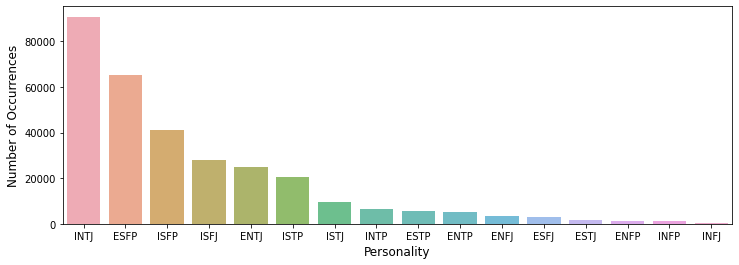

In [59]:
model_lr.fit(train_data['clean_posts'], train_data['type'])
pred_all = model_lr.predict(forum_data_agg['clean_messages'])

cnt_all = np.unique(pred_all, return_counts=True)

pred_df = pd.DataFrame({'personality': cnt_all[0], 'count': cnt_all[1]},
                      columns=['personality', 'count'], index=None)

pred_df.sort_values('count', ascending=False, inplace=True)

plt.figure(figsize=(12,4))
sns.barplot(x=pred_df['personality'], y=pred_df['count'], alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Personality', fontsize=12)
plt.show()

In [60]:
pred_df['percent'] = pred_df['count']/pred_df['count'].sum()
pred_df['description'] = pred_df['personality'].apply(lambda x: ' '.join([mbti[l] for l in list(x)]))

In [61]:
pred_df

,personality,count,percent,description
10,INTJ,90742,0.294819,Introversion Intuition Thinking Judging
5,ESFP,65321,0.212227,Extroversion Sensing Feeling Perceiving
13,ISFP,40884,0.132831,Introversion Sensing Feeling Perceiving
12,ISFJ,27949,0.090806,Introversion Sensing Feeling Judging
2,ENTJ,24879,0.080831,Extroversion Intuition Thinking Judging
15,ISTP,20638,0.067052,Introversion Sensing Thinking Perceiving
14,ISTJ,9637,0.031310,Introversion Sensing Thinking Judging
11,INTP,6561,0.021317,Introversion Intuition Thinking Perceiving
7,ESTP,5461,0.017743,Extroversion Sensing Thinking Perceiving
3,ENTP,5105,0.016586,Extroversion Intuition Thinking Perceiving


In [62]:
import plotly.graph_objs as go
import plotly.offline as py


labels = pred_df['description']
sizes = pred_df['percent']*100
 
trace = go.Pie(labels=labels, values=sizes)
layout = go.Layout(title='Kaggle Personality Distribution')
 
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)


Creating pickle file and testing

In [67]:
import pickle
pickle.dump(model_lr, open("model-lr.pkl", "wb"))

In [73]:
query = forum_data_agg['clean_messages']

model = pickle.load(open('model-lr.pkl', 'rb'))
prediction = model.predict(query)

In [75]:
display(prediction)

'INTJ'

Creating mock data

In [78]:
forum_data_agg['clean_messages'].to_csv('example.csv')